In [1]:
# Imports
import numpy as np
import pandas as pd

### The Data

In [2]:
# Load the data
data = pd.read_csv('train.csv')

In [3]:
# Check the head
data.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [4]:
# Let's see the shape
data.shape

(913000, 4)

In [5]:
# Checking how many unique values
print('How many stores:', data['store'].nunique())

print('And how many items:', data['item'].nunique())

How many stores: 10
And how many items: 50


In [6]:
# Checking the dtypes
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


In [7]:
# Transform the date column to datetime object
data['date'] = pd.to_datetime(data['date'])

In [8]:
# Creating new features
data['day'] = data['date'].dt.day
data['month'] = data['date'].dt.month
data['year'] = data['date'].dt.year

In [9]:
data.head()

,date,store,item,sales,day,month,year
0,2013-01-01,1,1,13,1,1,2013
1,2013-01-02,1,1,11,2,1,2013
2,2013-01-03,1,1,14,3,1,2013
3,2013-01-04,1,1,13,4,1,2013
4,2013-01-05,1,1,10,5,1,2013


### Exploratory Data Analysis

In [10]:
# More imports and some visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# Magic command
%matplotlib inline

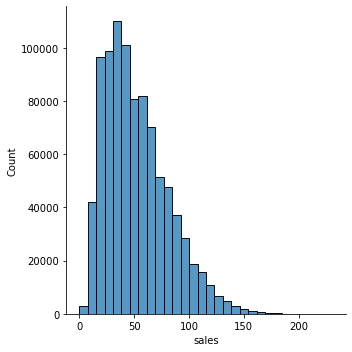

In [11]:
# The sales feature
sns.displot(data['sales'], bins=30) # The average sales price is around 50

<AxesSubplot:title={'center':'Total Sales by Year'}, xlabel='date', ylabel='sales'>

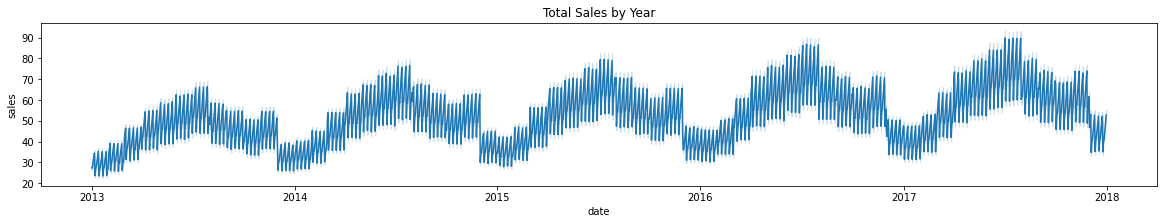

In [12]:
plt.figure(figsize=(20,3))
plt.title('Total Sales by Year')
sns.lineplot(x='date',y='sales',data=data) # There is a slightly upward trend in sales

In [13]:
# Now we'll isolate only one store and one item for forecast
X = data[(data['store']==1)&(data['item']==1)]
X.shape

(1826, 7)

<AxesSubplot:title={'center':'Total Sales by Month for Item 1 and Store 1'}, xlabel='month', ylabel='sales'>

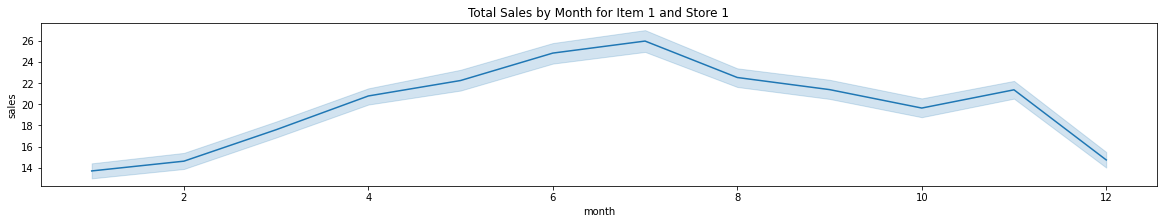

In [14]:
plt.figure(figsize=(20,3))
plt.title('Total Sales by Month for Item 1 and Store 1') # July is the best month for sales
sns.lineplot(x='month',y='sales',data=X)

<AxesSubplot:title={'center':'Total Sales by Day for Item 1 and Store 1'}, xlabel='day', ylabel='sales'>

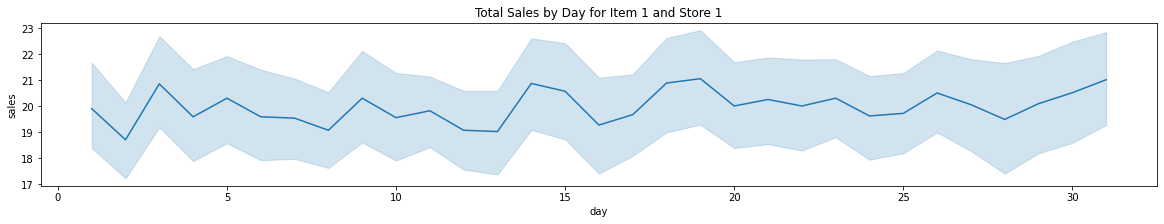

In [15]:
plt.figure(figsize=(20,3))
plt.title('Total Sales by Day for Item 1 and Store 1')
sns.lineplot(x='day',y='sales',data=X)

### Modeling and Forecasting

In [16]:
# Loading the model and make predictions
from fbprophet import Prophet

In [17]:
# We need to put these names in the columns
X = X.rename(columns ={'date':'ds', 'sales':'y'})

In [18]:
model = Prophet(growth='linear', interval_width=0.95, daily_seasonality=False)

In [19]:
# Let's fit the model
model.fit(X)

In [20]:
# And make some predictions
future = model.make_future_dataframe(periods=90, freq='D') # Put the scope of time
forecast = model.predict(future)

In [21]:
# Import the metrics to evaluate
from fbprophet.diagnostics import cross_validation, performance_metrics

In [22]:
df_cv = cross_validation(model, initial='720 days', period='90 days', horizon='180 days')
df_cv.head()

INFO:fbprophet:Making 11 forecasts with cutoffs between 2015-01-16 00:00:00 and 2017-07-04 00:00:00


  0%|          | 0/11 [00:00<?, ?it/s]

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2015-01-17,17.322413,8.824805,24.993791,16,2015-01-16
1,2015-01-18,18.390398,10.227929,26.420843,15,2015-01-16
2,2015-01-19,11.075072,3.331216,19.043163,12,2015-01-16
3,2015-01-20,13.067369,5.489704,20.712140,12,2015-01-16
4,2015-01-21,14.068837,5.902941,21.292874,10,2015-01-16


In [23]:
# Checking the metrics
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,coverage
0,18 days,23.379103,4.835194,3.826041,0.211691,0.142962,0.898990
1,19 days,22.537647,4.747383,3.813819,0.216593,0.145799,0.904040
2,20 days,22.139420,4.705254,3.787265,0.214378,0.145799,0.909091
3,21 days,22.789083,4.773791,3.909704,0.221621,0.154540,0.914141
4,22 days,22.591112,4.753011,3.883079,0.223046,0.149489,0.919192


In [24]:
df_p.tail()

,horizon,mse,rmse,mae,mape,mdape,coverage
158,176 days,22.677098,4.762048,3.594212,0.201443,0.133143,0.914141
159,177 days,23.814548,4.880015,3.720713,0.206335,0.138846,0.904040
160,178 days,23.711111,4.869406,3.716706,0.207300,0.138846,0.904040
161,179 days,23.102402,4.806496,3.693244,0.204147,0.141493,0.914141
162,180 days,23.822319,4.880811,3.789726,0.207857,0.147390,0.909091


In [25]:
mape = df_p['mape'].mean() # A MAPE around 20% is good, we don't reach that
print(mape)

0.21001577358572673


In [26]:
# More imports
from fbprophet.plot import plot_cross_validation_metric

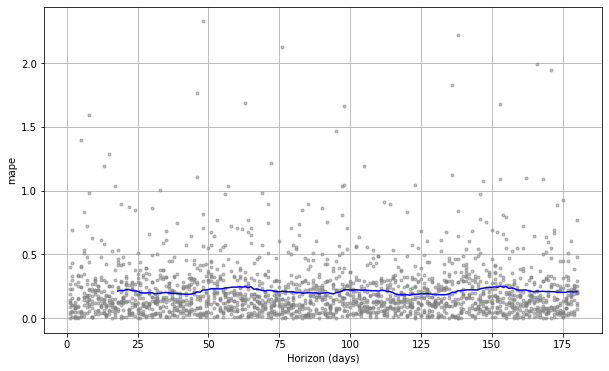

In [27]:
# Let's plot the evaluate metrics
fig = plot_cross_validation_metric(df_cv, metric='mape')

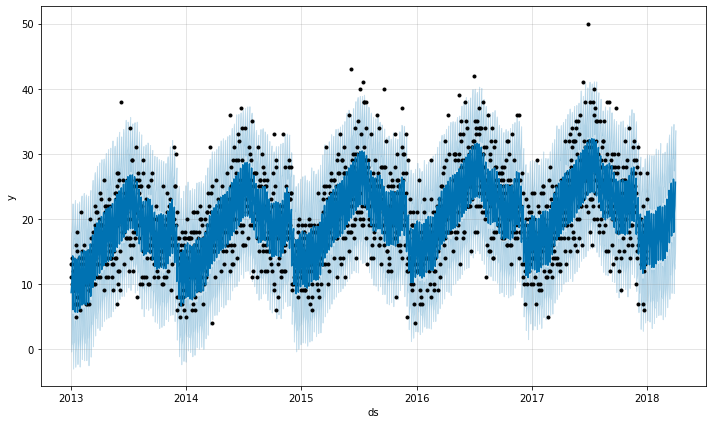

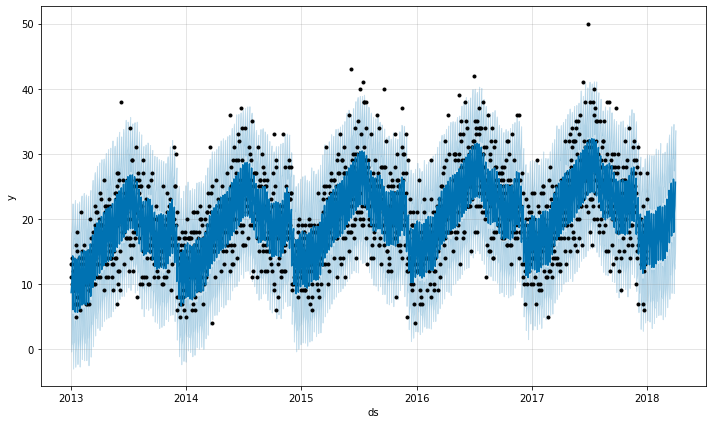

In [28]:
model.plot(forecast)

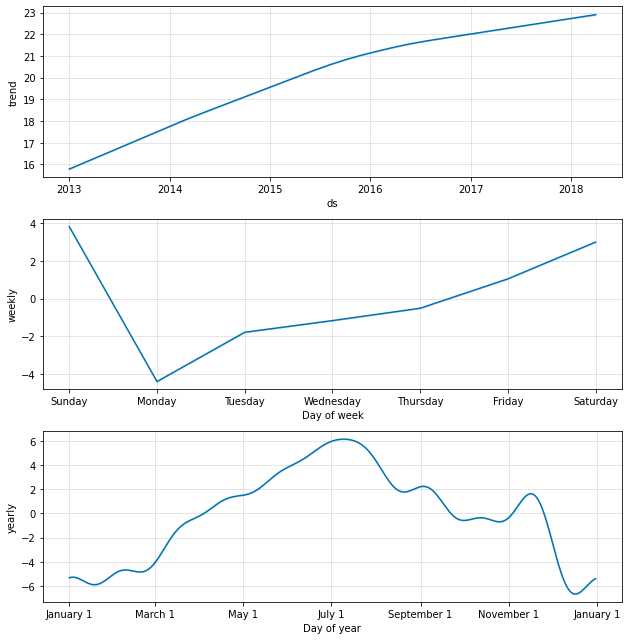

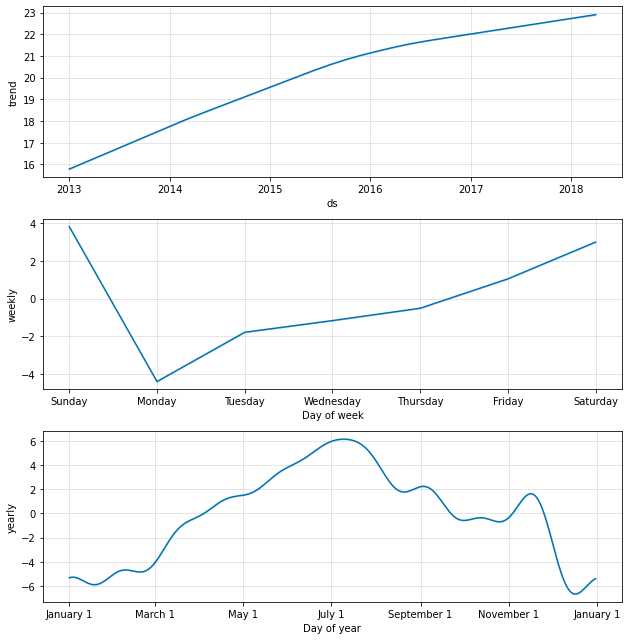

In [29]:
model.plot_components(forecast)

### Conclusion: Our model was pretty good to forecast sales, with a MAPE around 20%